In [1]:
import numpy as np
import scipy

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from cobra.LCDM.LCDM import CobraLCDM
from cobra.Utils.convert_units import convert_units_k_pk_from_hfid
from scipy.interpolate import CubicSpline

import camb 
from camb import model, initialpower 
from camb.dark_energy import DarkEnergyPPF, DarkEnergyFluid
from camb.reionization import TanhReionization 

### Computing weights for a given input spectrum

If you don't want to make any use of the built-in RBF emulators (which may be the case if you want to exceed their ranges, for example) then there is also the option of providing your own set of weights for the linear or one-loop calculation. Let's do an example!

In [2]:
## call CAMB for a cosmology with a nonzero neutrino mass and a nontrivial DE equation of state
h=0.65
pars = camb.set_params(kmax = 20) 
pars.set_cosmology(H0=100*h, ombh2=0.022, omch2=0.12, mnu=0.6,TCMB=2.7255)
pars.InitPower.set_params(ns=0.95,As=2.2e-9)
pars.set_accuracy(AccuracyBoost=3)
pars.DarkEnergy=DarkEnergyPPF(w=-0.5, wa=0)
pars.set_matter_power(redshifts=[1], kmax=20, accurate_massive_neutrino_transfers=True)
results = camb.get_results(pars)

kh, z, pk1 = results.get_matter_power_spectrum(minkh=1e-4, maxkh=20, npoints = 600)
p_out_camb_mnuw0 = pk1[0]

We can try to decompose this power spectrum into the cobra basis.


In [3]:
k_pk_mnu = np.array([kh,p_out_camb_mnuw0])
cobra_lcdm_ext = CobraLCDM(param_range = 'ext')
wts, proj = cobra_lcdm_ext.project_pk_into_basis(k_pk_mnu, h, n_basis_list=[12])


The projection is again in units of h_fid / Mpc, so to compare to the input we have to convert units again.

In [4]:

proj_h = convert_units_k_pk_from_hfid(proj, h_out = h) ## gives back k_pk array

## let's compare them on the range of proj (which is narrower):
camb_spl = CubicSpline(np.log10(kh),p_out_camb_mnuw0)(np.log10(proj_h[0]))

Using the maximum number of 16 available basis functions, we can approximate the power spectrum with neutrinos quite well:

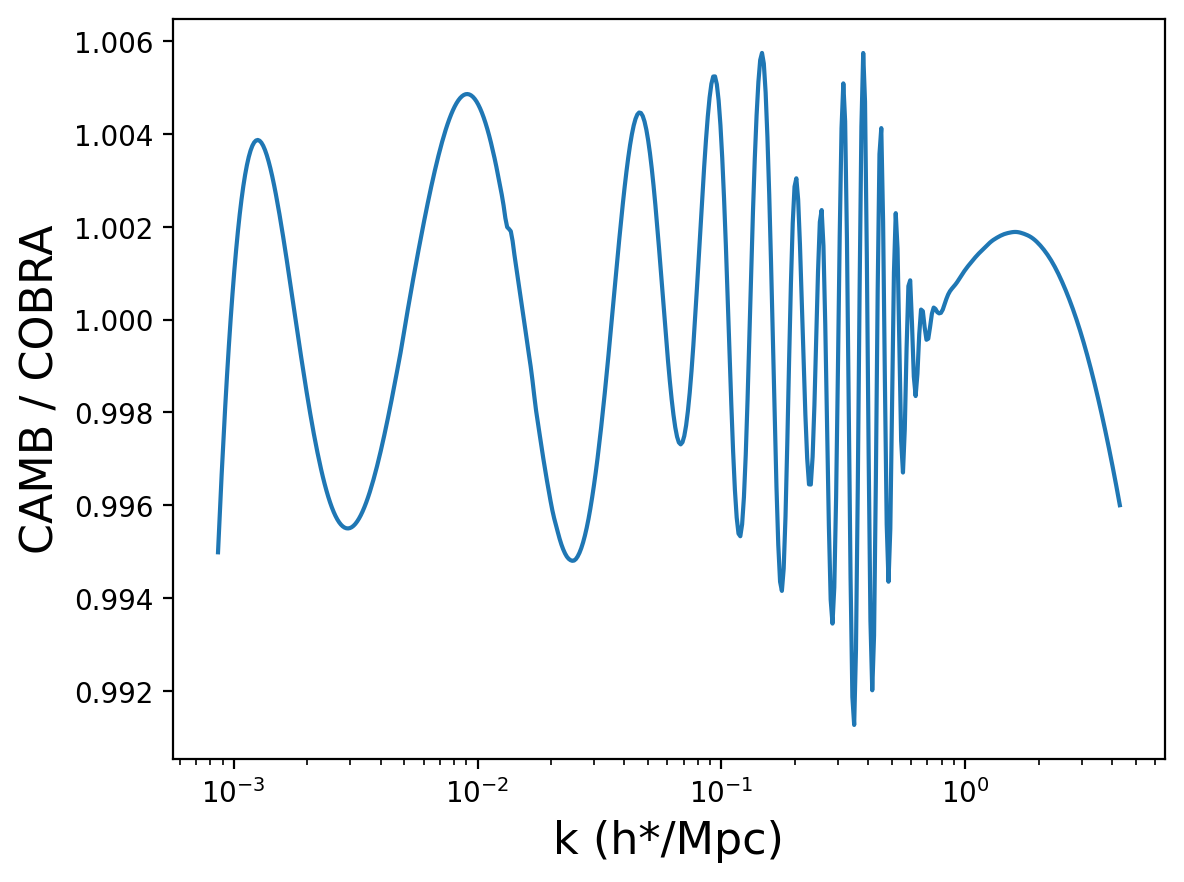

In [5]:
plt.xscale('log')
plt.plot(proj_h[0],camb_spl / proj_h[1])
plt.xlabel('k (h*/Mpc)',fontsize=16)
plt.ylabel('CAMB / COBRA',fontsize=16)
plt.show()


You can now use the weights as inputs for a loop calculation, putting the cosmology argument to 'None'. This of course still assumes that you can model all the dependence on cosmological parameters only via the input power spectrum. Let's put the growth rate equal to unity for simplicity. For the theory model and implementation of velocileptors we use here, see https://github.com/sfschen/velocileptors/blob/master/velocileptors/EPT/ept_fullresum_fftw.py and https://arxiv.org/pdf/2005.00523, https://arxiv.org/abs/2012.04636.

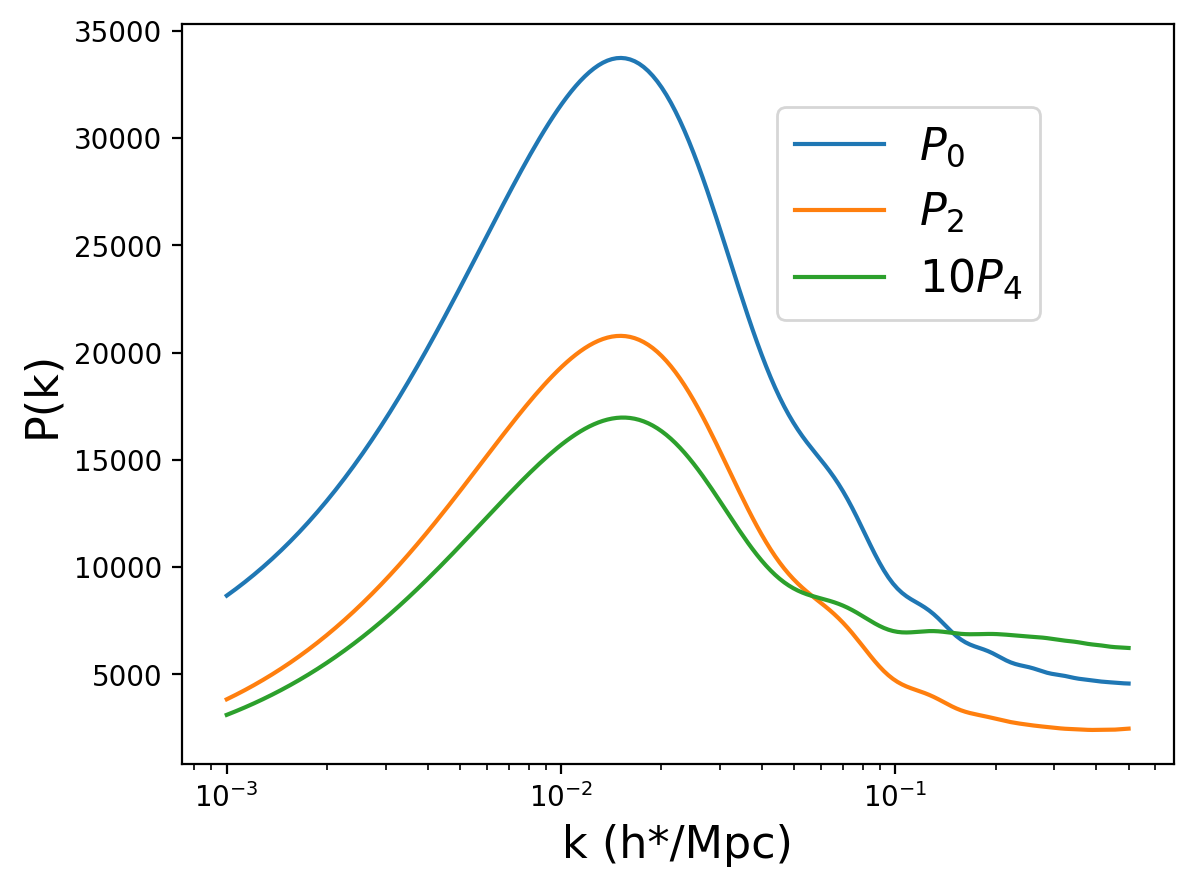

In [6]:
bias_params_ept = {'b1':[1.68593608], 'b2':[-1.17], 'bs':[-0.715], 'b3':[-0.479], \
               'alpha0':[50], 'alpha2':[50], 'alpha4':[50], 'alpha6':[50], \
               'sn':[3000], 'sn2':[3000], 'sn4':[3000], 'bfog':[0]}

k_out_loop = cobra_lcdm_ext.s_tables_loop["k_loop"] #take the internal wavenumbers for simplicity

pell_mnuw0 = cobra_lcdm_ext.oneloop_galaxy_power_multipoles(cosmo = None, weights = np.array([wts]), bias = bias_params_ept,
                                                            n_basis_list = [12,12], k_out_hfid = k_out_loop, growth_rates = np.array([1]),
                                                         resum = False)[0]

plt.xscale('log')
plt.plot(k_out_loop, pell_mnuw0[0])
plt.plot(k_out_loop, pell_mnuw0[1])
plt.plot(k_out_loop, 10*pell_mnuw0[2])
plt.legend([r'$P_0$',r'$P_2$',r'$10 P_4$'],loc=[0.6,0.6],fontsize = 16)
plt.xlabel('k (h*/Mpc)',fontsize=16)
plt.ylabel('P(k)',fontsize=16)
plt.show()